In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import imageio
import numpy as np
import flowermodel.find_blobs as fb
from tqdm import tqdm
import ipywidgets as widgets
from flowermodel import plotting  
import pandas as pd
import glob

In [ ]:
!flowermodel framecount --filename ../data/movies/41586_2019_1429_MOESM4_ESM.mov

In [ ]:
!mkdir pbslogs

In [ ]:
%%writefile blob.pbs
#!/bin/bash
#PBS -l nodes=1:ppn=2
#PBS -l walltime=0:10:00
#PBS -l mem=4GB
#PBS -q batch
#PBS -N blob
#PBS -t 0-270
#PBS -o pbslogs/$PBS_JOBNAME.o
#PBS -e pbslogs/$PBS_JOBNAME.e

cd $PBS_O_WORKDIR
FILE="../data/movies/41586_2019_1429_MOESM4_ESM.mov"
. /projects/chuang-lab/jnh/miniconda3/etc/profile.d/conda.sh
conda activate flower
flowermodel blob --filename $FILE --blob-index $PBS_ARRAYID

In [ ]:
# !qsub blob.pbs

In [ ]:
# import pandas as pd
# import glob
# moviefile = '41586_2019_1429_MOESM4_ESM.mov'
# files = glob.glob('../data/blobs/{:s}/blob*.csv'.format(moviefile))
# blobs = [pd.read_csv(file) for file in files]
# blobs = pd.concat(blobs).sort_values(['frame', 'color', 'x', 'y']).reset_index(drop=True)

# blobs.to_csv('../data/blobs/{:s}.blob.csv'.format(moviefile), index=False)

In [3]:
moviefile = '41586_2019_1429_MOESM4_ESM.mov'
blobs = pd.read_csv('../data/blobs/{:s}.blob.csv'.format(moviefile))

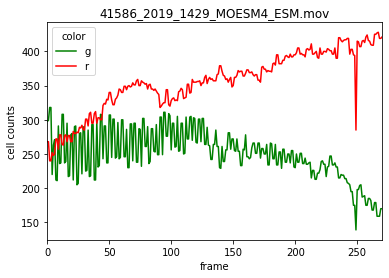

In [7]:
blobcounts = blobs.groupby(['frame', 'color']).size().unstack()
blobcounts.plot(color=['g', 'r'])
plt.ylabel('cell counts');
plt.title(moviefile);

In [5]:
filename = '../data/movies/{:s}'.format(moviefile)
vid = imageio.get_reader(filename,  'ffmpeg')

def f(img_idx):
    plotting.plot_blob_overlay(vid, img_idx, blobs);

interactive_plot = widgets.interactive(f, img_idx=widgets.IntSlider(
    min=0, max=vid.count_frames()-1, continuous_update=False))

output = interactive_plot.children[-1]
output.layout.height = '550px'
output.layout.width = '550px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='img_idx', max=270), Output(layo…

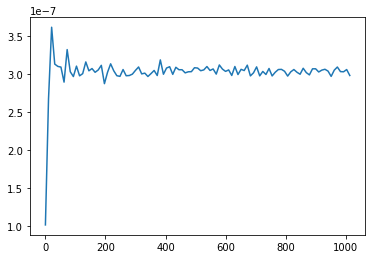

In [304]:
from flowermodel.calculate_rdf import framerdf

image_idx = 100
color1 = 'g'
color2 = 'r'

rdf = blobrdf(vid, blobs, image_idx, color1, color2)#rdfobj.calculate_rdf()
plt.plot(rdf.rvals, rdf.rdf);

In [343]:
class Parent:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c


class Child(Parent):
    def __init__(self, d, *args):
        super(Child, self).__init__(*args)
        self.d = d
        
c = Child(1, 2, 3, 4)    
c.a

2

In [350]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

class __vidrdf__:
    def __init__(self, blobfile, color1, color2):
        import imageio
        self.blobs = pd.read_csv(blobfile)
        self.vid = imageio.get_reader(filename,  'ffmpeg')
        self.num_frames = self.vid.count_frames()
        (self.L1, self.L2, _) = self.vid.get_data(0).shape
        self.maxL = min(self.L1, self.L2)       

class vidrdf(__vidrdf__):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vid_qc()

    def get_rdf(self):       
        rdfs = []
        for image_idx in tqdm(range(self.num_frames)):
            rdf = framerdf(vid, self.blobs, image_idx, color1, color2)
            rdfs.append(rdf.rdf)
        rvals = rdf.rvals
        return rvals, rdfs

    def vid_qc(self):
        assert np.all(np.diff(np.array([self.vid.get_data(0).shape for n in range(self.num_frames)]), 
                      axis=0) == 0), 'Some video frames have a different size'
           
        if self.L1!=self.L2: 
            print('The images are not exactly squares. Using the minumum dimension for analysis')

class framerdf(__vidrdf__):
    def __init__(self, blobfile, image_idx, color1, color2, nbins=100):
        super().__init__(blobfile, color1, color2)
        
        blob = self.blobs[self.blobs['frame'] == image_idx]
        self.X1 = blob.loc[blob['color'] == color1, ['x', 'y']].values
        self.X2 = blob.loc[blob['color'] == color2, ['x', 'y']].values

        self.get_blob_dists()
        self.get_cell_counts_for_rdf()
        
        self.rvals, self.rdf = self.calculate_rdf(nbins=nbins)
        

    def get_blob_dists(self):
        '''
        This function calculates pairwise distance between all blobs
        of 'color1' to blobs of 'color2' assuming periodic boundary
        conditions (only for one iteration).
        '''
        from scipy.spatial import distance_matrix

        dists = []
        for i in [0, -self.L1, self.L1]:
            for j in [0, -self.L2, self.L2]:
                X2shift = self.X2 + [i, j]
                dist = distance_matrix(self.X1, X2shift)
                dists.append(dist)
        self.dist = np.hstack(dists)

    def get_cell_counts_for_rdf(self):
        '''
        This function finds the number of cells for RDF calculation, 
        given the periodic boundary conditions, and the assumption that 
        pairs of cells further than minimum dimension of the image 
        should be ignored. Because of periodic boundary conditions 
        some cells (with 'color2') may never be used in the analysis and hence are
        not counted toward the total count.
        ''' 
        self.N = (self.dist <= self.maxL).sum()

    def calculate_point_rdf(self, r1, r2):
        a = np.pi * (r2**2 - r1**2)
        rdf = ((r1 <= self.dist) & (self.dist < r2)).sum()/ self.N/ a
        return rdf
    
    
    def calculate_rdf(self, nbins=100):

        rvals = np.linspace(0, self.maxL, nbins)

        rdf = np.zeros_like(rvals)
        for idx in range(len(rvals)-1):
            rdf[idx] = self.calculate_point_rdf(rvals[idx], rvals[idx+1])

        rvals = rvals[:-1]
        rdf = rdf[:-1]

        return rvals, rdf            
            
# rdf = []
# for image_idx in tqdm(range(vid.count_frames())):
#     rdf = framerdf(vid, blobs, image_idx, color1, color2)

rdf = framerdf(blobfile, image_idx, color1, color2, nbins=100)

In [351]:
v = vidrdf(blobfile, color1, color2)

In [353]:
rvals, rdfs = v.get_rdf()

ValueError: Invalid file path or buffer object type: <class 'imageio.plugins.ffmpeg.FfmpegFormat.Reader'>

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

class vidrdf:
    def __init__(self, blobfile, color1, color2):
        import imageio
        self.color1 = color1
        self.color2 = color2
        self.blobs = pd.read_csv(blobfile)
        self.vid = imageio.get_reader(filename,  'ffmpeg')
        self.num_frames = self.vid.count_frames()
        (self.L1, self.L2, _) = self.vid.get_data(0).shape
        self.maxL = min(self.L1, self.L2)
        
        self.vid_qc(self.vid)

    def get_rdf():        
        rdf = []
        for image_idx in tqdm(range(sef.num_frames)):
            rdf = framerdf(vid, self.blobs, image_idx, color1, color2)
        
#     def 
#         image_idx = 10
#         self.rdf = framerdf(blobfile, image_idx, color1, color2, nbins=100)

    def vid_qc(self, vid):
        assert np.all(np.diff(np.array([self.vid.get_data(0).shape for n in range(self.num_frames)]), 
                      axis=0) == 0), 'Some video frames have a different size'
           
        if self.L1!=self.L2: 
            print('The images are not exactly squares. Using the minumum dimension for analysis')

class framerdf:
    def __init__(self, vid, blobs, image_idx, color1, color2, nbins=100):
        blob = blobs[blobs['frame'] == image_idx]
        self.X1 = blob.loc[blob['color'] == color1, ['x', 'y']].values
        self.X2 = blob.loc[blob['color'] == color2, ['x', 'y']].values


#         (self.L1, self.L2, _) = vid.get_data().shape
        
        self.get_blob_dists()
        self.get_cell_counts_for_rdf()
        
        self.rvals, self.rdf = self.calculate_rdf(nbins=nbins)
        

    def get_blob_dists(self):
        '''
        This function calculates pairwise distance between all blobs
        of 'color1' to blobs of 'color2' assuming periodic boundary
        conditions (only for one iteration).
        '''
        from scipy.spatial import distance_matrix

        dists = []
        for i in [0, -self.L1, self.L1]:
            for j in [0, -self.L2, self.L2]:
                X2shift = self.X2 + [i, j]
                dist = distance_matrix(self.X1, X2shift)
                dists.append(dist)
        self.dist = np.hstack(dists)

    def get_cell_counts_for_rdf(self):
        '''
        This function finds the number of cells for RDF calculation, 
        given the periodic boundary conditions, and the assumption that 
        pairs of cells further than minimum dimension of the image 
        should be ignored. Because of periodic boundary conditions 
        some cells (with 'color2') may never be used in the analysis and hence are
        not counted toward the total count.
        ''' 

        self.maxL = min(self.L1, self.L2)
        self.N = (self.dist <= self.maxL).sum()

    def calculate_point_rdf(self, r1, r2):
        a = np.pi * (r2**2 - r1**2)
        rdf = ((r1 <= self.dist) & (self.dist < r2)).sum()/ self.N/ a
        return rdf
    
    
    def calculate_rdf(self, nbins=100):

        rvals = np.linspace(0, self.maxL, nbins)

        rdf = np.zeros_like(rvals)
        for idx in range(len(rvals)-1):
            rdf[idx] = self.calculate_point_rdf(rvals[idx], rvals[idx+1])

        rvals = rvals[:-1]
        rdf = rdf[:-1]

        return rvals, rdf          
            
# rdf = []
# for image_idx in tqdm(range(vid.count_frames())):
#     rdf = framerdf(vid, blobs, image_idx, color1, color2)

rdf = framerdf(blobfile, image_idx, color1, color2, nbins=100)

In [ ]:
vidrdf(blobfile, color1, color2)

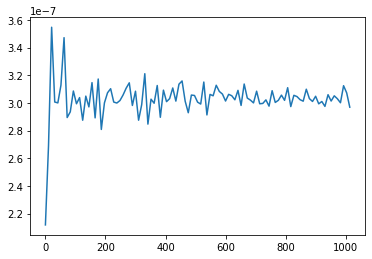

In [320]:
plt.plot(rdf.rvals, rdf.rdf)

In [315]:
moviefile = '41586_2019_1429_MOESM4_ESM.mov'
blobfile = '../data/blobs/{:s}.blob.csv'.format(moviefile)

# Scratch

In [290]:
color1 = 'g'
color2 = 'r'

rdfobj = blobrdf(vid, blobs, image_idx, color1, color2)

first_iter = True
for image_idx in range(vid.count_frames()):
    rdfobj = blobrdf(vid, blobs, image_idx, color1, color2)

    if first_iter:
        rvals = np.linspace(0, rdfobj.maxL, 100)
        rdf = np.zeros((len(rvals)))
        first_iter = False
    for idx in range(len(rvals)-1):
        rdf[idx] = rdfobj.calculate_rdf(rvals[idx], rvals[idx+1])

rvals = rvals[:-1]
rdf = rdf[:, :-1]    

271

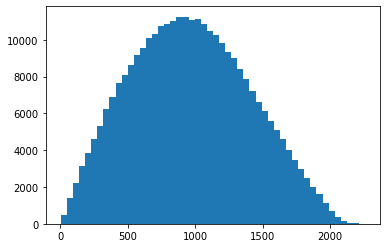

In [255]:
plt.hist(rdfobj.dist[:, :rdfobj.L2].flatten(), 50);

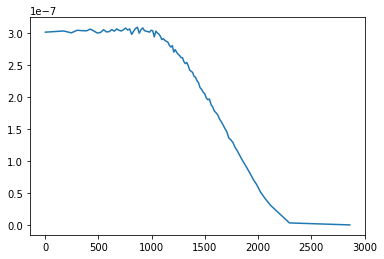

In [260]:
nbins = 100
q = 1/nbins

rvals = [np.quantile(rdfobj.dist, q * idx) for idx in range(nbins+1)]

rdf = np.zeros_like(rvals)
for idx in range(len(rvals)-1):
    rdf[idx] = rdfobj.calculate_rdf(rvals[idx], rvals[idx+1])
    
plt.plot(rvals, rdf);

In [1]:
# from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return x

widgets.interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [ ]:
import MDAnalysis
from MDAnalysis.tests.datafiles import PSF,DCD  # test trajectory
import numpy.linalg
u = MDAnalysis.Universe(PSF,DCD)  # always start with a Universe
nterm = u.select_atoms('segid 4AKE and name N')[0]  # can access structure via segid (s4AKE) and atom name
cterm = u.select_atoms('segid 4AKE and name C')[-1]  # ... takes the last atom named 'C'
bb = u.select_atoms('protein and backbone')  # a selection (a AtomGroup)
for ts in u.trajectory:  # iterate through all frames
    r = cterm.position - nterm.position  # end-to-end vector from atom positions
    d = numpy.linalg.norm(r)   # end-to-end distance
    rgyr = bb.radius_of_gyration()  # method of a AtomGroup; updates with each frame
    print( "frame = %d: d = %f Angstroem, Rgyr = %f Angstroem" % (ts.frame, d, rgyr))
    
    

In [ ]:
from flowermodel import plotting  
img_idx = 0
plotting.plot_blob_overlay(vid, img_idx, blobs)    

In [ ]:
blobs.to_csv(os.path.join(outputdir, 'blob{:d}.csv'.format(blob_idx)), index=False)

In [ ]:
import os
from flowermodel import util
blob_idx = 3
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
outputdir = os.path.join('../data/blobs/', os.path.basename(filename))
util.mkdir_if_not_exist(outputdir)

blobs = fb.get_allframes_blobs(filename, min_idx=blob_idx, max_idx=blob_idx+1)
blobs.to_csv(os.path.join(outputdir, 'blob{:d}.csv'.format(blob_idx)))

In [ ]:
# filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
# allblobs = fb.get_allframes_blobs(filename)

In [ ]:
%%bash
flowermodel blob --filename ../data/movies/41586_2019_1429_MOESM4_ESM.mov --blob-index 2 

In [ ]:
# from skimage.restoration import inpaint_biharmonic, denoise_wavelet
# from skimage.morphology import disk, square
# from skimage.filters import rank
# from skimage.util import img_as_ubyte
# from skimage.exposure import equalize_hist, equalize_adapthist
# from skimage.feature import blob_dog, blob_log, blob_doh

def remove_text(img):
    th = threshold_otsu(img[:, :, 2])
    mask = img[:, :, 2] > th
    newimg = img.copy()
    newimg[:, :, 2] = 0
    newimg = inpaint_biharmonic(newimg, mask, multichannel=True)
    return newimg

def get_image(vid, img_idx):
    img = vid.get_data(img_idx)
    img = remove_text(img)
    # img = img[35:-42, :, :] # remove annotations on the image
    return img

In [ ]:
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')

In [ ]:
vid.count_frames()

In [ ]:
img_idx = 0
img = get_image(vid, img_idx)

plt.figure(figsize=(8,8))
plt.imshow(img)

In [ ]:
import pandas as pd

# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

def get_blobs(imgray, min_sigma=3, max_sigma=10, num_sigma=10, threshold=.1, opening_disk_radius = 5):
#     imgray_opened = opening((imgray * 256).astype(int), disk(opening_disk_radius))/256     
    blobs = blob_log(imgray, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)
    blobs = pd.DataFrame(blobs, columns=['x', 'y', 'radius'])
    blobs['radius'] *= np.sqrt(2)
    return blobs

def plot_blobs(blobs, ax, color='r'):
    for y, x, r in blobs:
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)
#         ax.set_axis_off()


def get_frame_blobs(img, min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1):
    '''
    This function finds all the blobs within the image and assigns them their corresponding color (GFP/RFP)
    '''
    blobs_r = get_blobs(img[:, :, 0], max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)
    blobs_g = get_blobs(img[:, :, 1], max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=num_sigma, threshold=threshold)   

    blobs_r['color'] = 'r'
    blobs_g['color'] = 'g'

    blobs = pd.concat([blobs_r, blobs_g])
    blobs.reset_index(drop=True, inplace=True)
    blobs[['x', 'y']] = blobs[['x', 'y']].astype(int)
    return blobs


filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')
img_idx = 100
img = get_image(vid, img_idx)
blobs = get_frame_blobs(img, min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1)
blobs['frame'] = img_idx

In [ ]:
# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)




def get_blobs(imgray, min_sigma=3, max_sigma=10, num_sigma=10, threshold=.1, opening_disk_radius = 5):
#     imgray_opened = opening((imgray * 256).astype(int), disk(opening_disk_radius))/256     
    blobs = blob_log(imgray, max_sigma=max_sigma, min_sigma=min_sigma,
                     num_sigma=num_sigma, threshold=threshold)
    blobs[:, 2] *= np.sqrt(2)
    return blobs

def plot_blobs(blobs, ax, color='r'):
    for y, x, r in blobs:
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)
#         ax.set_axis_off()

_, ax = plt.subplots(1, 1, figsize=(8,8))
img_idx = 100
img = get_image(vid, img_idx)

ax.imshow(img)

blobs_r = get_blobs(img[:, :, 0], min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1, opening_disk_radius = 5)
blobs_g = get_blobs(img[:, :, 1], min_sigma=10, max_sigma=15, num_sigma=10, threshold=.1, opening_disk_radius = 5)

plot_blobs(blobs_r, ax, color='red')
plot_blobs(blobs_g, ax, color='green')

In [ ]:
plt.figure(figsize=(8,8))
th = threshold_otsu(imgray_opened)
plt.imshow(imgray_opened > th)

In [ ]:
plt.hist(equalize_hist(imgray_opened.flatten()), 50);

In [ ]:
imgray_denoised = denoise_wavelet(imgray, multichannel=False)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(imgray_denoised)

In [ ]:
plt.hist(imgray.flatten(), 50);

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(imgray > 0.6)

In [ ]:
imgray = img[:, :, 0]
imgray = (imgray * 256).astype(int)
plt.figure(figsize=(8,8))
plt.imshow(imgray)

In [ ]:

# selem = square(300)
# img_eq = rank.equalize(img_as_ubyte(imgray), selem=selem)
img_eq = equalize_hist(imgray)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(img_eq)

In [ ]:
from skimage.morphology import opening

plt.figure(figsize=(8,8))
plt.imshow(opening(img_eq, disk(5)))

In [ ]:
plt.figure(figsize=(8,8))
imgray_opened = opening(imgray, disk(5))
plt.imshow(imgray_opened/256)
plt.colorbar()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(imgray_opened/256 > 0.1)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(equalize_hist(imgray_opened)); 

In [ ]:
filename = '../data/movies/41586_2019_1429_MOESM4_ESM.mov'
vid = imageio.get_reader(filename,  'ffmpeg')

im = 0
for image in vid.iter_data():
    im += image[:, :, 2] > 200

im = im/vid.count_frames()    
metadata = vid.get_meta_data()

plt.imshow(im);
plt.figure()
plt.plot(im.sum(axis=1))

In [ ]:

imsum = im.sum(axis=1)
th = imsum[:imsum.shape[0]//2].max()/2
# imsum = (imsum > th).astype(int)
# plt.plot(imsum)
# imsumdiff = np.diff(imsum)
# plt.plot(imsumdiff)

In [ ]:
plt.imshow(img[:, :, 2])

In [ ]:
plt.plot(img[:, :, 2].sum(axis=1))

In [ ]:
img.shape

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, 0])

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(img[:, :, 1])

In [ ]:
from scipy.signal import find_peaks
height = imsum[:imsum.shape[0]//2].max()/2
find_peaks(imsum, height=height, width=10)[0]